In [1]:
# Dependencies 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import linregress
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from census import Census
import pandas as pd
%matplotlib inline
import numpy as np
import requests
import gmaps
import time
import json
import re

# Census & gmaps API Keys

from config import gkey
gmaps.configure(api_key=gkey)

# DATA CLEANING STEPS

### First dataset on Zillow Home Value Index, Median Sale Price, Monthly Home Sales, Foreclosure Resales
#### Source Zillow

In [2]:
# ZHVI All Homes (SFR, Condo/Co-op) Time Series ($) (by ZIP code)
csv_home_values = "Resources/Zip_Zhvi_AllHomes.csv"

# Median Sale Price - Seasonally Adjusted ($) (by ZIP code)
csv_home_sales = "Resources/Sale_Prices_Zip.csv"

# Monthly Home Sales (Number, Raw) (by ZIP code)
csv_number_sales = "Resources/Sale_Counts_Zip.csv"

# Foreclosure Resales (%) (by ZIP code)
csv_foreclosure_resales = "Resources/SalesPrevForeclosed_Share_Zip.csv"

home_values = pd.read_csv(csv_home_values, encoding="ISO-8859-1")
home_sales = pd.read_csv(csv_home_sales, encoding="ISO-8859-1")
number_sales = pd.read_csv(csv_number_sales, encoding="ISO-8859-1")
foreclosure_resales = pd.read_csv(csv_foreclosure_resales, encoding="ISO-8859-1")

# Suffixes:
# ZVHI = Zillow Home Value Index ($)
# MSR = Median Sales Price - Seasonally Adjusted ($)
# NS = Number of Sales
# FR = Foreclosure Resales (%)

In [3]:
# Python Dictionary to translate US States to Two letter codes
# Dictionary obtained from rogerallen (https://gist.github.com/rogerallen/1583593)
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH',
    'Oklahoma': 'OK','Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
}

# Rename StateName columns
home_values = home_values.rename(columns={"RegionName":"ZIP Code",
                                          "2008-01":"2008-01_ZHVI",
                                          "2008-02":"2008-02_ZHVI"})
home_sales = home_sales.rename(columns={"RegionName":"ZIP Code",
                                        "StateName":"State"})
number_sales = number_sales.rename(columns={"RegionName":"ZIP Code",
                                            "StateName":"State",
                                            "seasAdj":"seasAdj_NS"})
foreclosure_resales = foreclosure_resales.rename(columns={"RegionName":"ZIP Code",
                                                          "StateName":"State"})

# Translate states into two letter codes for each file and handle errors
try:
    for index, row in home_sales.iterrows():
        state = home_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        home_sales.loc[index, "State"] = abbr

    for index, row in number_sales.iterrows():
        state = number_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        number_sales.loc[index, "State"] = abbr

    for index, row in foreclosure_resales.iterrows():
        state = foreclosure_resales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        foreclosure_resales.loc[index, "State"] = abbr
except:
    pass

In [4]:
# Merge the home_values, home_sales, number_sales and foreclosure_resales
merge1 = pd.merge(home_values, home_sales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_ZHVI", "_MSR"))
merge2 = pd.merge(number_sales, foreclosure_resales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_NS", "_FR"))
main_data = pd.merge(merge1, merge2, on=["ZIP Code","State","RegionID"], how="outer")

#### Explore Data To Show U.S Housing Price From 2008 - 2019

In [5]:
# Function to get mean of the columns from minimum month and year to maximum month and year with different suffixes
# Used regular expressions
def findavg(data,year,suffix):
    x = []
    for i in data.columns:
        # Find all words matching the year and suffix and append to x
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].mean(axis=1)
    return data[f"{year}_Avg_{suffix}"]

In [6]:
# Grabbed the 'RegionID', 'ZIP Code', 'City', 'State', 'CountyName' columns from main_data
new_main_data = main_data[['RegionID', 'ZIP Code', 'City', 'State', 'CountyName']]
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName
0,84654,60657,Chicago,IL,Cook County
1,61637,10023,New York,NY,New York County
2,91982,77494,Katy,TX,Harris County
3,84616,60614,Chicago,IL,Cook County
4,91940,77449,Katy,TX,Harris County


In [7]:
#Join all suffixes across different years to new_main_data
years = [i for i in range(2008,2020,1)]
suffixes = ["ZHVI","MSR","NS","FR"]

for year in years:
    for suffix in suffixes:
        new_main_data = new_main_data.join(findavg(main_data,year,suffix))
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName,2008_Avg_ZHVI,2008_Avg_MSR,2008_Avg_NS,2008_Avg_FR,2009_Avg_ZHVI,...,2017_Avg_NS,2017_Avg_FR,2018_Avg_ZHVI,2018_Avg_MSR,2018_Avg_NS,2018_Avg_FR,2019_Avg_ZHVI,2019_Avg_MSR,2019_Avg_NS,2019_Avg_FR
0,84654,60657,Chicago,IL,Cook County,479900.645833,376410.0,146.9,0.00000,466041.694444,...,213.000000,0.004208,4.886200e+05,3.704417e+05,179.750000,0.005367,4.835098e+05,4.097091e+05,131.090909,0.006700
1,61637,10023,New York,NY,New York County,NaN,NaN,NaN,NaN,833515.733333,...,75.333333,NaN,1.216848e+06,1.115458e+06,77.500000,NaN,1.176796e+06,1.146527e+06,71.909091,NaN
2,91982,77494,Katy,TX,Harris County,267059.388889,243020.0,79.2,0.03512,267583.416667,...,257.666667,0.002967,3.329190e+05,3.316750e+05,253.916667,0.001367,3.340930e+05,3.250500e+05,242.400000,0.007025
3,84616,60614,Chicago,IL,Cook County,606633.729167,NaN,NaN,NaN,594972.111111,...,215.400000,0.002430,6.361214e+05,4.334167e+05,197.416667,0.001183,6.297365e+05,5.015000e+05,153.000000,0.006750
4,91940,77449,Katy,TX,Harris County,125067.777778,NaN,125.7,0.24388,119876.111111,...,157.083333,0.012083,1.760530e+05,1.764667e+05,158.083333,0.003492,1.830033e+05,1.878727e+05,162.818182,0.011450


##### First Dataframe with Suffixes:

**ZVHI = Zillow Home Value Index                                       
** MSR = Median Sales Price (Seasonally Adjusted)     
** NS = Number of Sales                                                        
** FR = Foreclosure Resales (%)

In [8]:
# Save the dataframe as a csv
new_main_data.to_csv("Output/zillow_data.csv", index=False,encoding="utf-8", header=True)

In [12]:
# Group the data by State and agrregated them by there mean across the zipcodes.
state_data_1 = new_main_data[
                     ['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI',
                      '2012_Avg_ZHVI', '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI',
                      '2017_Avg_ZHVI', '2018_Avg_ZHVI', '2019_Avg_ZHVI', '2008_Avg_MSR','2009_Avg_MSR', 
                      '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR','2013_Avg_MSR', '2014_Avg_MSR', 
                      '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR', '2018_Avg_MSR', '2019_Avg_MSR', 
                      '2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS','2013_Avg_NS', 
                      '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS', '2018_Avg_NS', '2019_Avg_NS', 
                      '2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']
                    ]\
                        .groupby("State")
state_data_1.head()

,RegionID,ZIP Code,City,State,CountyName,2008_Avg_ZHVI,2008_Avg_MSR,2008_Avg_NS,2008_Avg_FR,2009_Avg_ZHVI,...,2017_Avg_NS,2017_Avg_FR,2018_Avg_ZHVI,2018_Avg_MSR,2018_Avg_NS,2018_Avg_FR,2019_Avg_ZHVI,2019_Avg_MSR,2019_Avg_NS,2019_Avg_FR
0,84654,60657,Chicago,IL,Cook County,479900.645833,376410.0,146.9,0.00000,466041.694444,...,213.000000,0.004208,4.886200e+05,3.704417e+05,179.750000,0.005367,4.835098e+05,4.097091e+05,131.090909,0.006700
1,61637,10023,New York,NY,New York County,NaN,NaN,NaN,NaN,833515.733333,...,75.333333,NaN,1.216848e+06,1.115458e+06,77.500000,NaN,1.176796e+06,1.146527e+06,71.909091,NaN
2,91982,77494,Katy,TX,Harris County,267059.388889,243020.0,79.2,0.03512,267583.416667,...,257.666667,0.002967,3.329190e+05,3.316750e+05,253.916667,0.001367,3.340930e+05,3.250500e+05,242.400000,0.007025
3,84616,60614,Chicago,IL,Cook County,606633.729167,NaN,NaN,NaN,594972.111111,...,215.400000,0.002430,6.361214e+05,4.334167e+05,197.416667,0.001183,6.297365e+05,5.015000e+05,153.000000,0.006750
4,91940,77449,Katy,TX,Harris County,125067.777778,NaN,125.7,0.24388,119876.111111,...,157.083333,0.012083,1.760530e+05,1.764667e+05,158.083333,0.003492,1.830033e+05,1.878727e+05,162.818182,0.011450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,100459,99801,Juneau,AK,Juneau Borough,327831.027778,NaN,22.0,0.00000,324280.194444,...,27.333333,0.006150,3.885153e+05,3.765833e+05,29.416667,0.000000,4.008204e+05,3.653200e+05,30.500000,0.000000
4776,59980,5701,Rutland,VT,Rutland County,201571.125000,NaN,4.0,0.05000,195480.138889,...,25.666667,0.047750,1.771021e+05,NaN,26.166667,0.091308,1.841202e+05,NaN,23.900000,0.091160
5059,59878,5403,South Burlington,VT,Chittenden County,244714.916667,NaN,0.7,0.00000,245448.555556,...,36.583333,0.000000,3.012889e+05,NaN,37.333333,0.017750,3.082549e+05,NaN,33.272727,0.005682
6308,59945,5641,Barre,VT,Washington County,174988.347222,NaN,9.6,0.00667,170009.972222,...,23.750000,0.042533,1.801787e+05,NaN,20.916667,0.038950,1.803209e+05,NaN,16.727273,0.024813


In [23]:
# Calculate average Zillow Home Value Index (ZHVI) per state
mean_zhvi = state_data_1[['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI', '2012_Avg_ZHVI',
                          '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI', '2017_Avg_ZHVI',
                          '2018_Avg_ZHVI', '2019_Avg_ZHVI']].mean()

# Calculate average Median Sales Price (MSR) per state
mean_msr = state_data_1[['State','2008_Avg_MSR','2009_Avg_MSR', '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR',
                         '2013_Avg_MSR', '2014_Avg_MSR', '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR',
                         '2018_Avg_MSR', '2019_Avg_MSR']].mean()

# Calculate total number of sales per state
sum_number_sales = state_data_1[['State','2008_Total_NS','2009_Total_NS', '2010_Total_NS', '2011_Total_NS', '2012_Total_NS',
                                 '2013_Total_NS', '2014_Total_NS', '2015_Total_NS', '2016_Total_NS','2017_Total_NS',
                                 '2018_Total_NS', '2019_Total_NS']].sum()

# Calculate average Foreclosure Resales (FR) per state
mean_fr = state_data_1[['State','2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']].mean()

# Put state data into dataframe
state_data_2 = pd.merge(mean_zhvi, mean_msr, on='State', how='outer')
state_data_3 = pd.merge(sum_number_sales, mean_fr, on='State', how='outer')
state_data = pd.merge(state_data_2, state_data_3, on='State', how='outer')


KeyError: "Columns not found: '2015_Total_NS', '2016_Total_NS', '2009_Total_NS', '2012_Total_NS', '2019_Total_NS', '2014_Total_NS', '2017_Total_NS', '2018_Total_NS', '2013_Total_NS', '2011_Total_NS', '2010_Total_NS', '2008_Total_NS'"

#### Data Exploation to Show Average U.S Housing Price,  Seasonally Adjusted Median Sales Price and Average Number of Home Sales From 2008 To 2019

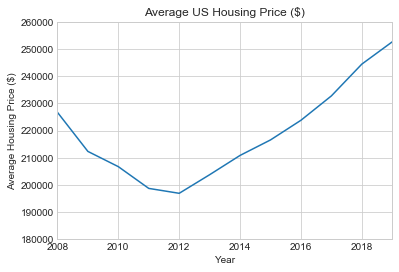

In [10]:
# Average U.S Housing Price
ave_home_values = [state_data["2008_Avg_ZHVI"].mean(), state_data["2009_Avg_ZHVI"].mean(),state_data["2010_Avg_ZHVI"].mean(),
                  state_data["2011_Avg_ZHVI"].mean(),state_data["2012_Avg_ZHVI"].mean(), state_data["2013_Avg_ZHVI"].mean(),
                  state_data["2014_Avg_ZHVI"].mean(), state_data["2015_Avg_ZHVI"].mean(), state_data["2016_Avg_ZHVI"].mean(),
                  state_data["2017_Avg_ZHVI"].mean(), state_data["2018_Avg_ZHVI"].mean(), state_data["2019_Avg_ZHVI"].mean()]
ave_home_values
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
plt.title("Average US Housing Price ($)")
plt.xlabel("Year")
plt.ylabel("Average Housing Price ($)")
plt.ylim(180000,260000)
plt.xlim(2008,2019)
plt.plot(years,ave_home_values)
plt.savefig("Output/average_house_price.png")

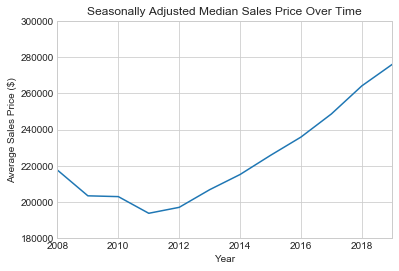

In [11]:
# Plot Of U.S Seasonally Adjusted Median Sales Price From 2008 To 2019
ave_sales_price = [state_data["2008_Avg_MSR"].mean(), state_data["2009_Avg_MSR"].mean(),state_data["2010_Avg_MSR"].mean(),
                  state_data["2011_Avg_MSR"].mean(),state_data["2012_Avg_MSR"].mean(), state_data["2013_Avg_MSR"].mean(),
                  state_data["2014_Avg_MSR"].mean(), state_data["2015_Avg_MSR"].mean(), state_data["2016_Avg_MSR"].mean(),
                  state_data["2017_Avg_MSR"].mean(), state_data["2018_Avg_MSR"].mean(), state_data["2019_Avg_MSR"].mean()]
plt.title("Seasonally Adjusted Median Sales Price Over Time")
plt.xlabel("Year")
plt.ylabel("Average Sales Price ($)")
plt.ylim(180000,300000)
plt.xlim(2008,2019)
plt.plot(years,ave_sales_price)
plt.savefig("Output/avg_sales_price.png")

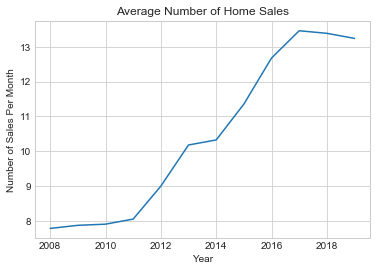

In [12]:
# Plot of Avg Number of Sales Per Month
ave_home_sales = [state_data["2008_Avg_NS"].mean(), state_data["2009_Avg_NS"].mean(),state_data["2010_Avg_NS"].mean(),
                  state_data["2011_Avg_NS"].mean(),state_data["2012_Avg_NS"].mean(), state_data["2013_Avg_NS"].mean(),
                  state_data["2014_Avg_NS"].mean(), state_data["2015_Avg_NS"].mean(), state_data["2016_Avg_NS"].mean(),
                  state_data["2017_Avg_NS"].mean(), state_data["2018_Avg_NS"].mean(), state_data["2019_Avg_NS"].mean()]
plt.title("Average Number of Home Sales")
plt.xlabel("Year")
plt.ylabel("Number of Sales Per Month")
plt.plot(years, ave_home_sales)
plt.savefig("Output/avg_num_sales.png")

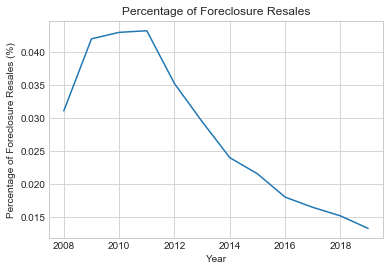

In [13]:
# Plot of Avg Foreclosure Resales
ave_foreclosure_resales = [state_data["2008_Avg_FR"].mean(), state_data["2009_Avg_FR"].mean(),state_data["2010_Avg_FR"].mean(),
                  state_data["2011_Avg_FR"].mean(),state_data["2012_Avg_FR"].mean(), state_data["2013_Avg_FR"].mean(),
                  state_data["2014_Avg_FR"].mean(), state_data["2015_Avg_FR"].mean(), state_data["2016_Avg_FR"].mean(),
                  state_data["2017_Avg_FR"].mean(), state_data["2018_Avg_FR"].mean(), state_data["2019_Avg_FR"].mean()]
plt.title("Percentage of Foreclosure Resales")
plt.xlabel("Year")
plt.ylabel("Percentage of Foreclosure Resales (%)")
plt.plot(years, ave_foreclosure_resales)
plt.savefig("Output/pct_foreclosure_sales.png")

In [14]:
state_data = state_data.reset_index()
housing_price_average = pd.DataFrame([state_data["State"],state_data["2008_Avg_ZHVI"],state_data["2009_Avg_ZHVI"], state_data["2010_Avg_ZHVI"],
                        state_data["2011_Avg_ZHVI"], state_data["2012_Avg_ZHVI"], state_data["2013_Avg_ZHVI"],
                         state_data["2014_Avg_ZHVI"], state_data["2015_Avg_ZHVI"], state_data["2016_Avg_ZHVI"],
                         state_data["2017_Avg_ZHVI"], state_data["2018_Avg_ZHVI"], state_data["2019_Avg_ZHVI"]
                        ]
                                    )
housing_price_average = housing_price_average.T

In [15]:
#states with highest increase and lowest decrease in housing prices 
housing_price_average["Change"] = housing_price_average["2019_Avg_ZHVI"] - housing_price_average["2008_Avg_ZHVI"]
#housing_price_average["Change"]
prices_descending = housing_price_average.sort_values(by=["Change"], ascending=False)
prices_descending.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,2018_Avg_ZHVI,2019_Avg_ZHVI,Change
7,DC,483599,458940,459613,459279,467900,506845,544902,563038,584612,609987,634940,662306,178707
4,CA,468234,423004,422986,401367,406447,446805,476875,503387,536483,569431,615508,626331,158098
5,CO,253619,245396,241199,237453,239758,255112,270234,292758,313756,331519,355129,370923,117304
47,WA,301550,274495,262044,241962,235502,252028,267069,286111,310318,339949,372879,384769,83219.3
19,MA,386248,364575,365931,354750,349036,366043,385413,403680,414750,430518,451397,459662,73414.3


In [16]:
prices_ascending = housing_price_average.sort_values(by=["Change"])
prices_ascending.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,2018_Avg_ZHVI,2019_Avg_ZHVI,Change
6,CT,347249,323905,313118,300228,288950,293718,294941,295012,298319,301334,306134,307665,-39583.8
31,NJ,420847,391781,380717,361595,349549,354848,366802,368909,370148,376509,389348,394467,-26379.7
20,MD,353504,319818,303927,293502,286752,295964,304431,305693,308862,318141,328421,333409,-20094.6
32,NM,216786,203819,199048,185493,181807,181872,181819,177094,179636,184753,189075,197808,-18978.8
49,WV,105933,102892,103330,98392.6,96010.1,95029.8,93818.4,88433.7,88496.3,88742.7,91196.2,93635.2,-12297.8


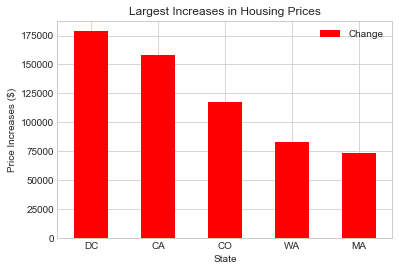

In [17]:
increase_df = pd.DataFrame({"State":["DC","CA","CO","WA","MA"],"Change":[178707,158098,117304,83219.2,73414.3]})
ax = increase_df.plot.bar(x="State", y="Change", color="red", rot=0)
ax.grid(True)
ax.set_axisbelow(True)
ax.yaxis.set_minor_locator(MultipleLocator(12500))
ax.set_ylabel("Price Increases ($)")
ax.title.set_text("Largest Increases in Housing Prices")
plt.savefig("Output/largest increases in house prices.png")

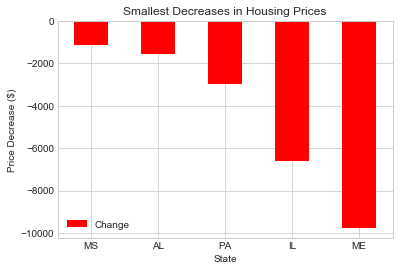

In [18]:
small_decrease_df = pd.DataFrame({"State":["MS","AL","PA","IL","ME"],"Change":[-1123.46,-1565.56,-2993.62,-6618.24,-9763.2]})
ax = small_decrease_df.plot.bar(x="State", y="Change", rot=0, color=["red"])
#ended up not using
ax.set_ylabel("Price Decrease ($)")
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.grid(True)
ax.set_axisbelow(True)
ax.title.set_text("Smallest Decreases in Housing Prices")

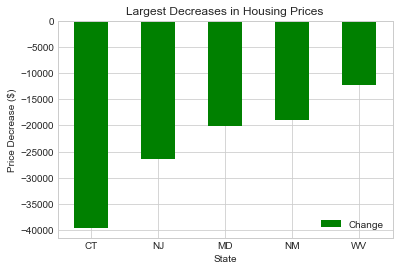

In [19]:
decrease_df = pd.DataFrame({"State":["CT","NJ","MD","NM","WV"],"Change":[-39583.8,-26379.7,-20094.5,-18978.8, -12297.8]})
ax = decrease_df.plot.bar(x="State", y="Change", rot=0, color="green")
ax.set_ylabel("Price Decrease ($)")
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.grid(True)
ax.set_axisbelow(True)
ax.title.set_text("Largest Decreases in Housing Prices")
plt.savefig("Output/largest_decreases.png")

### Second Dataset on Divorce Rate Across All States in the U.S
#### Rates are based on provisional counts of divorces by state of occurrence.  Rates are per 1,000 total population residing in area. 
#### Source: CDC/NCHS, National Vital Statistics System.

In [20]:
#Get divorce-rate and convert to dataframe
divorce_csv = "Resources/divorce-rate.xlsx"

divorce_rate = pd.read_excel(divorce_csv, encoding="ISO-8859-1")

In [21]:
# Translate states into two letter codes and handle errors
try:
    for index, row in divorce_rate.iterrows():
        state = divorce_rate.loc[index, "State"]
        abbr = us_state_abbrev[state]
        divorce_rate.loc[index, "State"] = abbr
except:
    pass

# Set index to "State" and change "Div Rate" to column names
divorce_rate = divorce_rate.set_index("State")
years = [i for i in range(2008,2020,1)]
new_divorce = divorce_rate[years[0:-1]]
[new_divorce.rename(columns = {i:f"{i}_Div Rate"}, inplace = True) \
             for i in range(2008,2020,1)]

# Replace missing values with "np.nan"
new_divorce = new_divorce.replace("---",np.nan)

C:\Users\Remco\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [22]:
# Merged main_data (zillow_data) with new_divorce (divorce data)
merge = state_data.join(new_divorce, on="State")

### Third Dataset on Unemployment Rate Across All States in the U.S
#### Source: Bureau of Labor Statistics.

In [23]:
# Get unemployment_csv and convert to dataframe
unemployment_csv = "Resources/Cleaned_BLS_Unemployment-Rate-by-State_2008-2019_1-11-2020.csv"
unemployment_data = pd.read_csv(unemployment_csv, encoding="ISO-8859-1")

# Rename "State" column and set index on "state"
unemployment_data = unemployment_data.rename(columns={"State Abbreviation":"State"}).set_index("State")

In [24]:
# Grab the numeric column headers, convert to string and concatenate "_unemployment"
unemployment_data = unemployment_data[[str(i) for i in range(2008,2020,1)]]
for i in range(2008,2020,1):
    unemployment_data = unemployment_data.rename(columns={str(i):f"{i}_unemployment"})
unemployment_data.head()

,2008_unemployment,2009_unemployment,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,
AL,5.72,10.99,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AK,6.71,7.73,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AZ,6.14,9.93,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
AR,5.50,7.83,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
CA,7.29,11.14,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [25]:
# Merged main_data (merge) with unemployment_data and round to 2 s.f
biggest_data = merge.join(unemployment_data, on="State").round(2)
biggest_data.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
4,CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,...,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


#### Data Exploration to Show Unemployment in U.S From 2008 To 2019

In [26]:
ave_unemployment = [biggest_data["2008_unemployment"].mean(), biggest_data["2009_unemployment"],biggest_data["2010_unemployment"],
                   biggest_data["2011_unemployment"].mean(), biggest_data["2012_unemployment"].mean(),biggest_data["2013_unemployment"].mean(),
                   biggest_data["2014_unemployment"].mean(), biggest_data["2015_unemployment"].mean(), biggest_data["2016_unemployment"].mean(),
                   biggest_data["2017_unemployment"].mean(), biggest_data["2018_unemployment"].mean(),biggest_data["2019_unemployment"].mean() ]

#largest decreases
ct_house_price = [347249.22, 323905.39, 313118.01, 300227.8, 288950.2, 293717.92, 294941.32, 295011.95, 298319.43, 301334.04, 306134.33, 307665]
nj_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
md_house_price = [353504, 319818, 303927, 293502, 286752, 295964, 304431, 305693, 308862, 318141, 328421, 333409]
nm_house_price = [216786, 203819, 199048, 185493, 181807, 181872, 181819, 177094, 179636, 184753, 189075, 197808]
wv_house_price = [105933, 102892, 103330, 98392.6, 96010.1, 95029.8, 93818.4, 88433.7, 88496.3, 88742.7, 91196.2, 93635.2]

#largest increases
dc_house_price = [483599, 458940, 459613, 459279, 467900, 506845, 544902, 563038, 584612, 609987, 634940, 662306]
ca_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
co_house_price = [253619, 245396, 241199, 237453, 239758, 255112, 270234, 292758, 313756, 331519, 355129, 370923]
wa_house_price = [301550, 274495, 262044, 241962, 235502, 252028, 267069, 286111, 310318, 339949, 372879, 384769]
ma_house_price = [386248, 364575, 365931, 354750, 349036, 366043, 385413, 403680, 414750, 430518, 451397, 459662]

y1 = ct_house_price
y2 = nj_house_price
y3 = md_house_price
y4 = nm_house_price
y5 = wv_house_price

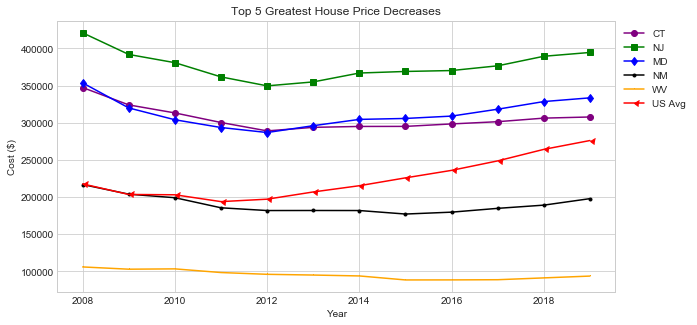

In [51]:
# Plot of Greatest Decrease
plt.figure(figsize=(10,5))
plt.plot(years, y1,marker='o', color="purple",label="CT")
plt.plot(years,y2,marker='s',color="green",label="NJ")
plt.plot(years,y3,marker='d',color="blue", label="MD")
plt.plot(years,y4,marker='.',color="black",label="NM")
plt.plot(years,y5,marker=',',color='orange',label="WV")
plt.plot(years, ave_sales_price, marker=4, color="red", label="US Avg")
plt.title("Top 5 Greatest House Price Decreases")
plt.xlabel("Year")
plt.ylabel("Cost ($)")
plt.legend(bbox_to_anchor=(1, 1), loc='best',
           ncol=1, 
           #mode="expand", borderaxespad=0.
          )
plt.savefig("Output/decreases_line.png")

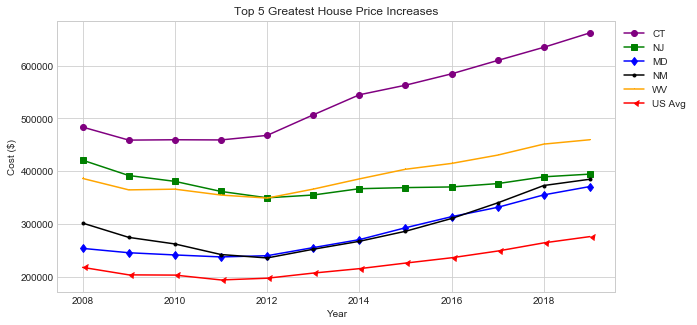

In [55]:
# Plot of Greatest Increase
y6 = dc_house_price
y7 = ca_house_price
y8 = co_house_price
y9 = wa_house_price
y10 = ma_house_price


plt.figure(figsize=(10,5))
plt.plot(years, y6, marker='o', color="purple",label="CT")
plt.plot(years, y7, marker='s',color="green",label="NJ")
plt.plot(years, y8, marker='d',color="blue", label="MD")
plt.plot(years, y9, marker='.',color="black",label="NM")
plt.plot(years, y10, marker=',',color='orange',label="WV")
plt.plot(years,ave_sales_price, marker=4, color="red", label="US Avg")
plt.title("Top 5 Greatest House Price Increases")
plt.xlabel("Year")
plt.ylabel("Cost ($)")
plt.legend(bbox_to_anchor=(1, 1), loc='best',
           ncol=1)
plt.savefig("Output/increases_line")

In [52]:
# Save the dataframe as a csv
biggest_data.to_csv("Output/zillow_divorce_unemployment.csv",encoding="utf-8", index=True, header=True)

### Fourth Dataset on Loans Across All States in the U.S
#### Source: New York Fed Consumer Credit Panel / Equifax.

In [53]:
# Get the sheets named "studentloan" and "total" from the excel worksheet
areaReport_csv = "Resources/area_report_by_year.xlsx"
sheetname = ["studentloan", "total"]
df = [" ", " "]

for i in range(len(sheetname)):
    df[i] = pd.read_excel(areaReport_csv, sheet_name=sheetname[i], encoding="ISO-8859-1")
    df[i] = df[i].iloc[2:len(df[i])-1,:]
    # store the header
    xls_header = df[i].iloc[0]
    df[i] = df[i][1:]
    # Use the stored header to name the columns
    df[i].columns = xls_header
    df[i] = df[i].set_index("state")
    df[i].rename_axis(None).index.name

# Unpack "df" list and assign the dataframes to variables
studentLoan_data = df[0]
totalLoan_data = df[1]

# Remove "Q4_" and concatenate "_studentloan" to column names in both dataframes
studentLoan_data = studentLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
totalLoan_data = totalLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
for i in range(2008,2019,1):
    studentLoan_data = studentLoan_data.rename(columns={f"Q4_{i}":f"{i}_studentLoan"})
    totalLoan_data = totalLoan_data.rename(columns={f"Q4_{i}":f"{i}_totalLoan"})
studentLoan_data.head()
totalLoan_data.head()

2,2008_totalLoan,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
state,,,,,,,,,,,
AK,54110,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,35540,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,28940,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,65870,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,86940,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


In [31]:
# Note => State "P.R" was dropped from dataframe due to missing values
# Merge studentloan and totalloan and round to 2 s.f
latest_merge = biggest_data.join(studentLoan_data, on="State")\
               .join(totalLoan_data, on="State").round(2)

latest_merge.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
4,CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,...,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


### Fifth Dataset on Median Household Income By States in the U.S
#### Source: United States Census Bureau

In [32]:
# Get income_csv, convert to dataframe and concatenate "_income" to column headers
income_csv = "Resources/us_income.xlsx"

income_data = pd.read_excel(income_csv, encoding="ISO-8859-1").set_index("State")
for i in range(2008,2020,1):
    income_data = income_data.rename(columns={i:f"{i}_income"})
income_data.head()

,2008_income,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
State,,,,,,,,,,,
AK,44476.0,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,63989.0,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,46914.0,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,39586.0,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,57014.0,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [33]:
# Merge income data to the overall data and round to 2 s.f
latest_merge = latest_merge.join(income_data, on="State")\
               .round(2)

latest_merge.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
4,CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,...,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [34]:
# Fill "NA" by average and round by 2
latest_merge.fillna(latest_merge.mean(), inplace=True)
latest_merge = latest_merge.round(2)
total_data = latest_merge
massive_data = latest_merge
massive_data = massive_data.drop(['2019_Avg_ZHVI','2019_Avg_MSR', '2019_Avg_NS', '2009_Avg_FR', '2019_unemployment'],axis=1)

In [35]:
# Save merged data to csv. Dataframe contains data from zillow, divorce rate, unemployment rate, loan and income rate
total_data.to_csv("Output/zillow_divorce_unemployment_loan_income.csv", index=True,encoding="utf-8", header=True)

### GMAPS - Visualizing Changes in Median Sales Price for States From 2008 - 2019

In [36]:
total_data = total_data.reset_index()
total_data["%Increase/Decrease_ZHVI"] = ((total_data["2018_Avg_ZHVI"] - total_data["2008_Avg_ZHVI"])/total_data["2008_Avg_ZHVI"]) * 100
total_data["%Increase/Decrease_MSR"] = ((total_data["2018_Avg_MSR"] - total_data["2008_Avg_MSR"])/total_data["2008_Avg_MSR"]) * 100
total_data["%Increase/Decrease_NS"] = ((total_data["2018_Avg_NS"] - total_data["2008_Avg_NS"])/total_data["2008_Avg_NS"]) * 100
total_data["%Increase/Decrease_FR"] = ((total_data["2018_Avg_FR"] - total_data["2008_Avg_FR"])/total_data["2008_Avg_FR"]) * 100
total_data["Lat"]=" "
total_data["Lng"]=" "

In [58]:
# Run state names through API and fetch longtitude and latitude values
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

params = {
    "key": gkey
}

for index, row in total_data.iterrows():
        state = row["State"]
        params["address"] = state
        response = requests.get(base_url, params)
        json_response = response.json()
        # Add lat and lng values to new columns
        total_data.loc[index, "Lat"] = json_response['results'][0]['geometry']['location']['lat']
        total_data.loc[index, "Lng"] = json_response['results'][0]['geometry']['location']['lng']

print(total_data[["State","Lat", "Lng"]])

   State      Lat      Lng
0     AK  36.7514 -95.9637
1     AL  32.3182 -86.9023
2     AR  36.1482 -95.9725
3     AZ  34.0489 -111.094
4     CA  36.7783 -119.418
5     CO  37.0366 -95.6714
6     CT  41.6032 -73.0877
7     DC  38.9072 -77.0369
8     DE  37.0902 -95.7129
9     FL  26.1224 -80.1373
10    GA  32.1656 -82.9001
11    HI  36.1481  -95.973
12    IA   41.878 -93.0977
13    ID  44.0682 -114.742
14    IL  40.6331 -89.3985
15    IN  40.2672 -86.1349
16    KS  39.0119 -98.4842
17    KY  37.8393   -84.27
18    LA  34.0522 -118.244
19    MA  42.4072 -71.3824
20    MD  35.5118 -97.5125
21    ME   37.223 -95.7078
22    MI  37.0902 -95.7129
23    MN  46.7296 -94.6859
24    MO  37.2006 -93.2807
25    MS  37.7948 -122.406
26    MT  46.8797 -110.363
27    NC  35.7596 -79.0193
28    ND  47.5515 -101.002
29    NE  41.4925 -99.9018
30    NH  43.1939 -71.5724
31    NJ  40.0583 -74.4057
32    NM  34.5199  -105.87
33    NV  38.8026 -116.419
34    NY  40.7128  -74.006
35    OH  40.4173 -82.9071
3

In [38]:
# Set conditions and create heatmap
coordinates = total_data[["Lat", "Lng"]]
pct_increase_msr = total_data["%Increase/Decrease_MSR"] + 100

fig = gmaps.figure(map_type="HYBRID")
heat_layer = gmaps.heatmap_layer(coordinates, weights=pct_increase_msr, dissipating=True, opacity=1, max_intensity = max(total_data["%Increase/Decrease_MSR"] + 100), point_radius = 3)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))


### (Not Used) Sixth Dataset on Population, Median Age and Median Year house was built By States in the U.S
#### Source: United States Census Bureau API
#### See: https://github.com/CommerceDataService/census-wrapper for library documentation
#### See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

In [39]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
def us_census(years):
    c = Census(api_key, year=years)
    
    # acs5 is a format for the data
    census_data = c.acs5.get(("NAME", "B01002_001E", "B25035_001E", "B01003_001E", "B01002_001E"), {'for': 'state:*'})
    
    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)
    
    # Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": f"{years} Population",
                                              "B01002_001E": f"{years} Median Age",
                                              "B25035_001E": f"{years} Median Year House was Built",
                                              "NAME": "State"})
    
    # Final DataFrame
    census_pd = census_pd[["State", f"{years} Population", f"{years} Median Age",
                                  f"{years} Median Year House was Built"]]
    
    # Translate states into two letter codes and handle errors
    try:
        for index, row in census_pd.iterrows():
            state = census_pd.loc[index, "State"]
            abbr = us_state_abbrev[state]
            census_pd.loc[index, "State"] = abbr
    except:
        pass
    return census_pd
    
# Run us_census function for years 2009 to 2018 and merge them together
census_df = us_census(2009)
i = 0
while i < 9:
    census_df = pd.merge(census_df, us_census(2010+i), on="State", how="outer")
    i += 1

# Reorder the dataframe to give better orientation and set index on "State"
census_df = census_df[[
    "State","2009 Population", "2010 Population", "2011 Population", "2012 Population","2013 Population", "2014 Population", "2015 Population", "2016 Population", "2017 Population",
    "2018 Population", "2009 Median Year House was Built", "2010 Median Year House was Built", "2011 Median Year House was Built", "2012 Median Year House was Built", "2013 Median Year House was Built",
    "2014 Median Year House was Built", "2015 Median Year House was Built", "2016 Median Year House was Built", "2017 Median Year House was Built", "2018 Median Year House was Built", "2009 Median Age",
    "2010 Median Age", "2011 Median Age", "2012 Median Age", "2013 Median Age", "2014 Median Age", "2015 Median Age", "2016 Median Age", "2017 Median Age", "2018 Median Age"
    ]].set_index("State")
census_df.head()

NameError: name 'api_key' is not defined

In [ ]:
# Save as a csv use encoding="utf-8"
census_df.to_csv("Output/census_data.csv", encoding="utf-8")

# DATA ANALYSIS ON CLEANED DATA

In [ ]:
def showStatedata(data):
    # Transpose data
    x = massive_data.T
    state = str(data).upper()
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]

    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    #Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    #print(state_df.corr())
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    print(f"{name_state}'s Strongest Pearson Correlation Factors")
    print("---------------------------------------------------")
    print(cor)
    
    # First plot
    plt.figure(figsize=(20,15))
    plt.subplot(2, 2, 1)
    corr_df = state_df[corr]
    y_values = state_df["Median Sales Price ($)"]
    plt.plot(corr_df.index, y_values, color = "r")
    plt.title(f'{name_state} {y_values.name} Vs {corr_df.index.name}',fontsize=14)
    plt.xlabel(f'{corr_df.index.name}')
    plt.ylabel(f'{y_values.name}')
    plt.grid(True)
    
    
    # Second Plot
    # Plot scatter plot
    plt.subplot(2, 2, 2)
    x_values = corr_df.iloc[:,0]
    plt.scatter(x_values, y_values, color='grey')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"b-")
    #plt.annotate(line_eq,(x_values.max()*0.6,y_values.max()*0.93),fontsize=15,color="red")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{y_values.name}', fontsize=14)
    plt.grid(True)
    
    
    # Third Plot
    # Plot scatter plot
    plt.subplot(2, 2, 3)
    x_values = corr_df.iloc[:,1]
    plt.scatter(x_values, y_values, color='brown')
    plt.title(f'{name_state} {state_df.columns.values[0]} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"g-")
    #plt.annotate(line_eq,(x_values.max()*0.6,y_values.max()*0.93),fontsize=15,color="black")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=14)
    plt.grid(True)
    
    
    # Fourth Plot
    # Plot scatter plot
    plt.subplot(2, 2, 4)
    x_values = corr_df.iloc[:,2]
    plt.scatter(x_values, y_values, color='green')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"y-")
    #plt.annotate(line_eq,(x_values.max()*0.85,y_values.max()*0.92),fontsize=15,color="red")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=14)
    plt.grid(True)
    plt.show
    plt.savefig(f"Output/{name_state} plots")
    return

In [ ]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest increase in MSR
greatest_increase = ["DC","CA","CO","WA","MA"]
[showStatedata(x) for x in greatest_increase]

In [ ]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest decrease in MSR
greatest_decrease = ["CT","NJ","MD","NM","WV"]
[showStatedata(x) for x in greatest_decrease]

In [ ]:
def predictmsr(data):
    # Transpose data
    x = massive_data.T
    state = str(data).upper()
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]

    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")

    #Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    #print(state_df.corr())
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    corr_df = state_df[corr]
    print(f"RUNNING MULTIPLE REGRESSION ON {name_state.upper()}")
    print("--------------------------------------------------------")    
    ## Convert to floats and store x and y values
    X = pd.DataFrame({corr_df.index.name:corr_df.index, 
                      corr_df.iloc[:,0].name:corr_df.iloc[:,0], 
                      corr_df.iloc[:,1].name:corr_df.iloc[:,1]})
    
    Y = state_df["Median Sales Price ($)"]
    
    # with sklearn
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)

    print('Intercept: \n', regr.intercept_)
    print('Coefficients: \n', regr.coef_)

    # New_Interest_Rate label and input box
    first =float(input(f'Type {X.iloc[:,0].name}: '))

    # New_Unemployment_Rate label and input box
    second =float(input(f'Type {X.iloc[:,1].name}: '))
   
    # New_Interest_Rate label and input box
    third = float(input(f'Type {X.iloc[:,2].name}: '))
    
    regr = round(int(regr.predict([[first ,second, third]])),2)
    print(f'Predicted {name_state} Median Sales Price: ${regr:,}')
    return 

In [ ]:
# Predict California MSR for any year based on strongest Correlation factors
predictmsr("cco")